In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
sys.path.append(r'E:\\CDEX\\ovbb\\calibration\\readTrc-master')     # the folder contain readTrc.py 
from readTrc import Trc
trc=Trc()
import time
from numba import jit
from scipy import signal

In [7]:
def TrapShapping(Vin,na,nb,nc,theta):
    d=math.exp(theta)
    N=Vin.shape[0]
    Vout=np.zeros((N,1))
    vi1=0
    vo1=0
    for k in np.arange(N):
        if(k-nc-1>=0):
            vi1=Vin[k-1]-Vin[k-na-1]-Vin[k-nb-1]+Vin[k-nc-1]
        elif(k-1<0):
            vi1=0
            vi2=0
        elif(k-na-1<0):
            vi1=Vin[k-1]
        elif(k-nb-1<0):
            vi1=Vin[k-1]-Vin[k-na-1]
        else:
            vi1=Vin[k-1]-Vin[k-na-1]-Vin[k-nb-1]
        
        if(k-1<0):
            vo1=0
            vo2=0
        else:
            vo1=Vout[k-1]

        Vout[k]=2*vo1-vo2+1/na*(vi1-d*vi2)
        vi2=vi1
        vo2=vo1
    return Vout

def ZACfilter(Taos,L,FT,deltaT,Tao):
    A=3*(2*Taos*(math.cosh(L/Taos)-1)+FT*math.sinh(L/Taos))/L**3
    print(A)
    Filter_length=2*L+FT
    Npoint=int(Filter_length/deltaT)
    conv=-math.exp(-deltaT/Tao)
    ZAC=np.arange(Npoint,dtype=float)
    FF =np.arange(Npoint-1,dtype=float)
    print(Npoint)
    ####################################################################
    for i in np.arange(Npoint):
        t=deltaT*i
        if(0<t and t<L ):
            ZAC[i]=math.sinh(t/Taos)+A*((t-L/2)**2-(L/2)**2)
        elif(L<=t and t<L+FT):
            ZAC[i]=math.sinh(L/Taos)
        elif(L+FT<=t and t<2*L+FT):
            ZAC[i]=math.sinh((2*L+FT-t)/Taos)+A*((3/2*L+FT-t)**2-(L/2)**2)
    #####################################################################
    #plt.plot(ZAC)
    for i in np.arange(Npoint-1):
        FF[i]=ZAC[i]*conv+ZAC[i+1]
    #####################################################################
    return FF,ZAC
   
def ZACshapping(Vin,FF):
    N_zac=FF.shape[0]
    N_vin=Vin.shape[0]
    N_vout=N_vin-N_zac+2
    Vout=signal.fftconvolve(FF,Vin)
    return Vout[N_zac:N_vin]
# def ZACshapping(Vin,FF):
#     N_zac=FF.shape[0]
#     N_vin=Vin.shape[0]
#     N_vout=N_vin-N_zac+2
#     Vout=np.arange(N_vout)
#     print(N_vout)
#     for i in np.arange(N_vout):
#         Vout[i]=0
#         for k in np.arange(i,i+N_zac-2):
#             Vout[i]+=Vin[k]*FF[i+N_zac-1-k]
#     return Vout

def PreAmp(Tao,deltaT,Time,Trigger,Amp,NoiseAmp):
    N_sample=int(Time/deltaT)
    Vout=np.arange(N_sample,dtype=float)
    Noise=NoiseAmp*np.random.randn(N_sample)
    for i in np.arange(N_sample):
        t=i*deltaT
        if(t<Trigger):
            Vout[i]=0
        else:
            Vout[i]=Amp*math.exp(-(t-Trigger)/Tao)
    return Vout+Noise

def DeConv(Tao,deltaT,Vin):  ################# Deconvolution
    N_Vout=Vin.shape[0]
    Vout=np.arange(N_Vout,dtype=float)
    A=math.exp(-deltaT/Tao)
    for i in np.arange(N_Vout):      
        if(i==0):
            Vout[i]=0
            continue
        else:
            Vout[i]=Vout[i-1]+Vin[i]-A*Vin[i-1]
    return Vout 

def TrapShapping_2(Vin,na,nb,nc,theta):
    a=np.array([1,-2,1])
    b=np.zeros((nc+3,))
    e=math.exp(theta)
    b[1]=1./na
    b[na+1]=-1./na
    b[nb+1]=-1./na
    b[nc+1]=1./na
    b[2]=-e/na
    b[na+2]=e/na
    b[nb+2]=e/na
    b[nc+2]=-e/na
    return signal.lfilter(b,a,Vin)

0.4017007350921631


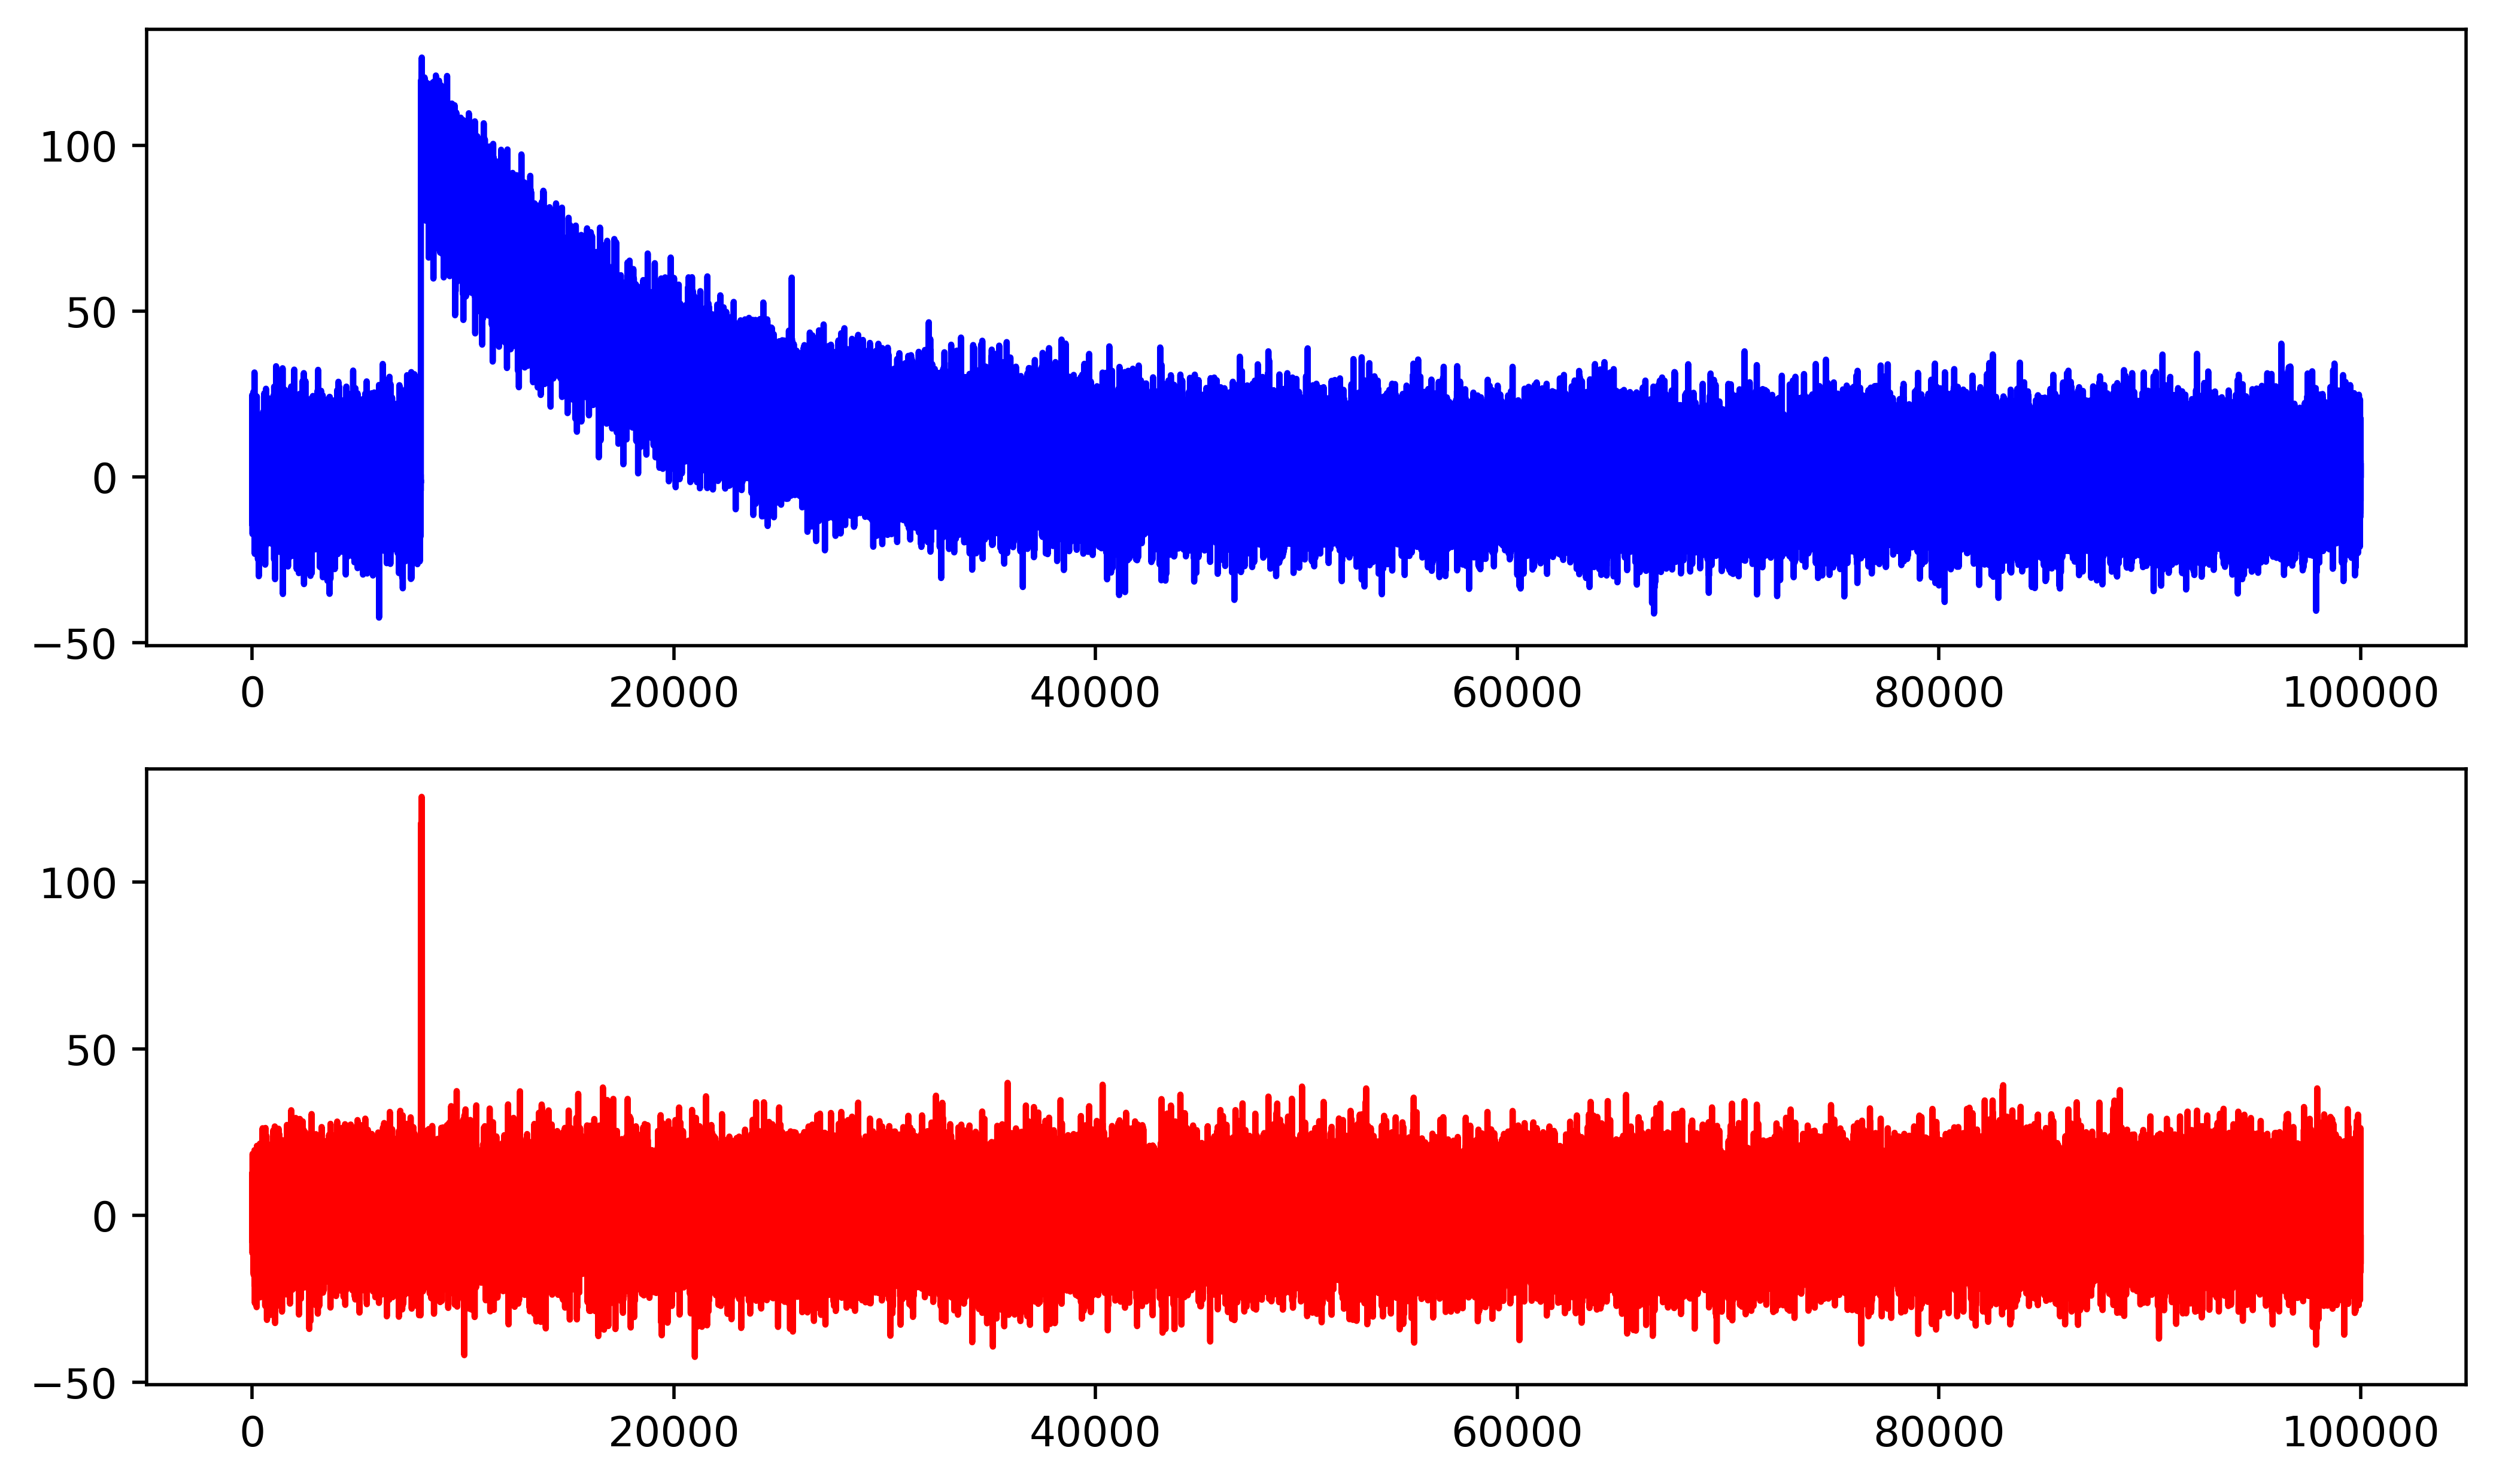

In [8]:
#parameters set here
#################
ns=0.001
us=ns*1000

NumOfEvents=1           # number of events
#################
Tao=100*us              #pre amp time constant  
deltaT=10*ns            #sampling interval

Amp=100                 #pre amp output amplitude

Time=1000*us             #sampling time window width

Trigger=80*us           #Trigger time point

NoiseAmp=10              #pre Amp pulse noise amplitude

na=1
nb=na+200
nc=nb+1                 #trapezoid shape parameter

##################
Taos=10*us              #cusp parameter            
Width=1500              #width of moving window deconvolution

#################
#################
NumOfEvents=1      # number of events

na=2
nb=na+50
nc=nb+2           #trapezoid shape parameter

MAW=10000          #Moving average window width

Tao=100*us         #time constant  
Ts=10*ns       #sampling interval
theta=-Ts/Tao
#################
##################
#Vin=np.zeros((16000,1))
Vin=PreAmp(Tao,deltaT,Time,Trigger,Amp,NoiseAmp)       #create a pre amplifier pulse

#Vout=DeConv(Tao,deltaT,Vin)
st=time.time()
for i in range(100):
    Vout=TrapShapping_2(Vin,na,nb,nc,theta)
##############################




# a=np.array([1,-2,1])
# b=np.zeros((nc+3,))
# e=math.exp(theta)
# b[1]=1./na
# b[na+1]=-1./na
# b[nb+1]=-1./na
# b[nc+1]=1./na
# b[2]=-e/na
# b[na+2]=e/na
# b[nb+2]=e/na
# b[nc+2]=-e/na
# st = time.time()
# Vout=signal.lfilter(b,a,Vin)
##############################
cost = time.time()-st
print(cost)
fig,ax=plt.subplots(2,1,figsize=(10,6),dpi=500)
ax[0].plot(Vin,color='b',label="Pre amplifier pulse")
ax[1].plot(Vout,color='r',label="ZAC filter")


In [9]:
#parameters set here
#################
ns=0.001
us=ns*1000

NumOfEvents=1           # number of events
#################
Tao=100*us              #pre amp time constant  
deltaT=10*ns            #sampling interval

Amp=1000                 #pre amp output amplitude
NoiseAmp=1
Time=40.96*us             #sampling time window width

Trigger=20.48*us           #Trigger time point

##################
Taos=10*us              #cusp parameter            #
FT=1*us                 #flat top width
L=16*us                 #length of one cusp side

#################

Vin=PreAmp(Tao,deltaT,Time,Trigger,Amp,5)

EventInfo=pd.DataFrame(index=np.arange(NumOfEvents),columns=['trapezoid max'])

FF,ZAC=ZACfilter(Taos,L,FT,deltaT,Tao)

Vout=ZACshapping(Vin,FF)

##################  plot

fig,ax=plt.subplots(2,2,figsize=(10,6),dpi=1200)
ax[0][0].plot(Vin,color='b',label="Pre amplifier pulse")
ax[0][1].plot(ZAC,color='r',label="ZAC filter")
ax[1][0].plot(FF,color='g',label="Final ZAC filter")
ax[1][1].plot(Vout,color='y',label="Wave form after convolution ")
ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
ax[1][1].legend()
fig.savefig(r'E:\CDEX\0vbb\Figure\E\ZAC.png')

0.024847307649241653
3300


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\\\CDEX\\\\ovbb\\\\calibration\\\\rootasy\\\\Spectrum\\\\calidata\\\\bin\\\\C1J6_No2_remove5Vamps_addC78_100nF_22uF_remove5.4V_withSiPM_DC1Mohm_28.5Vop_00000.trc'

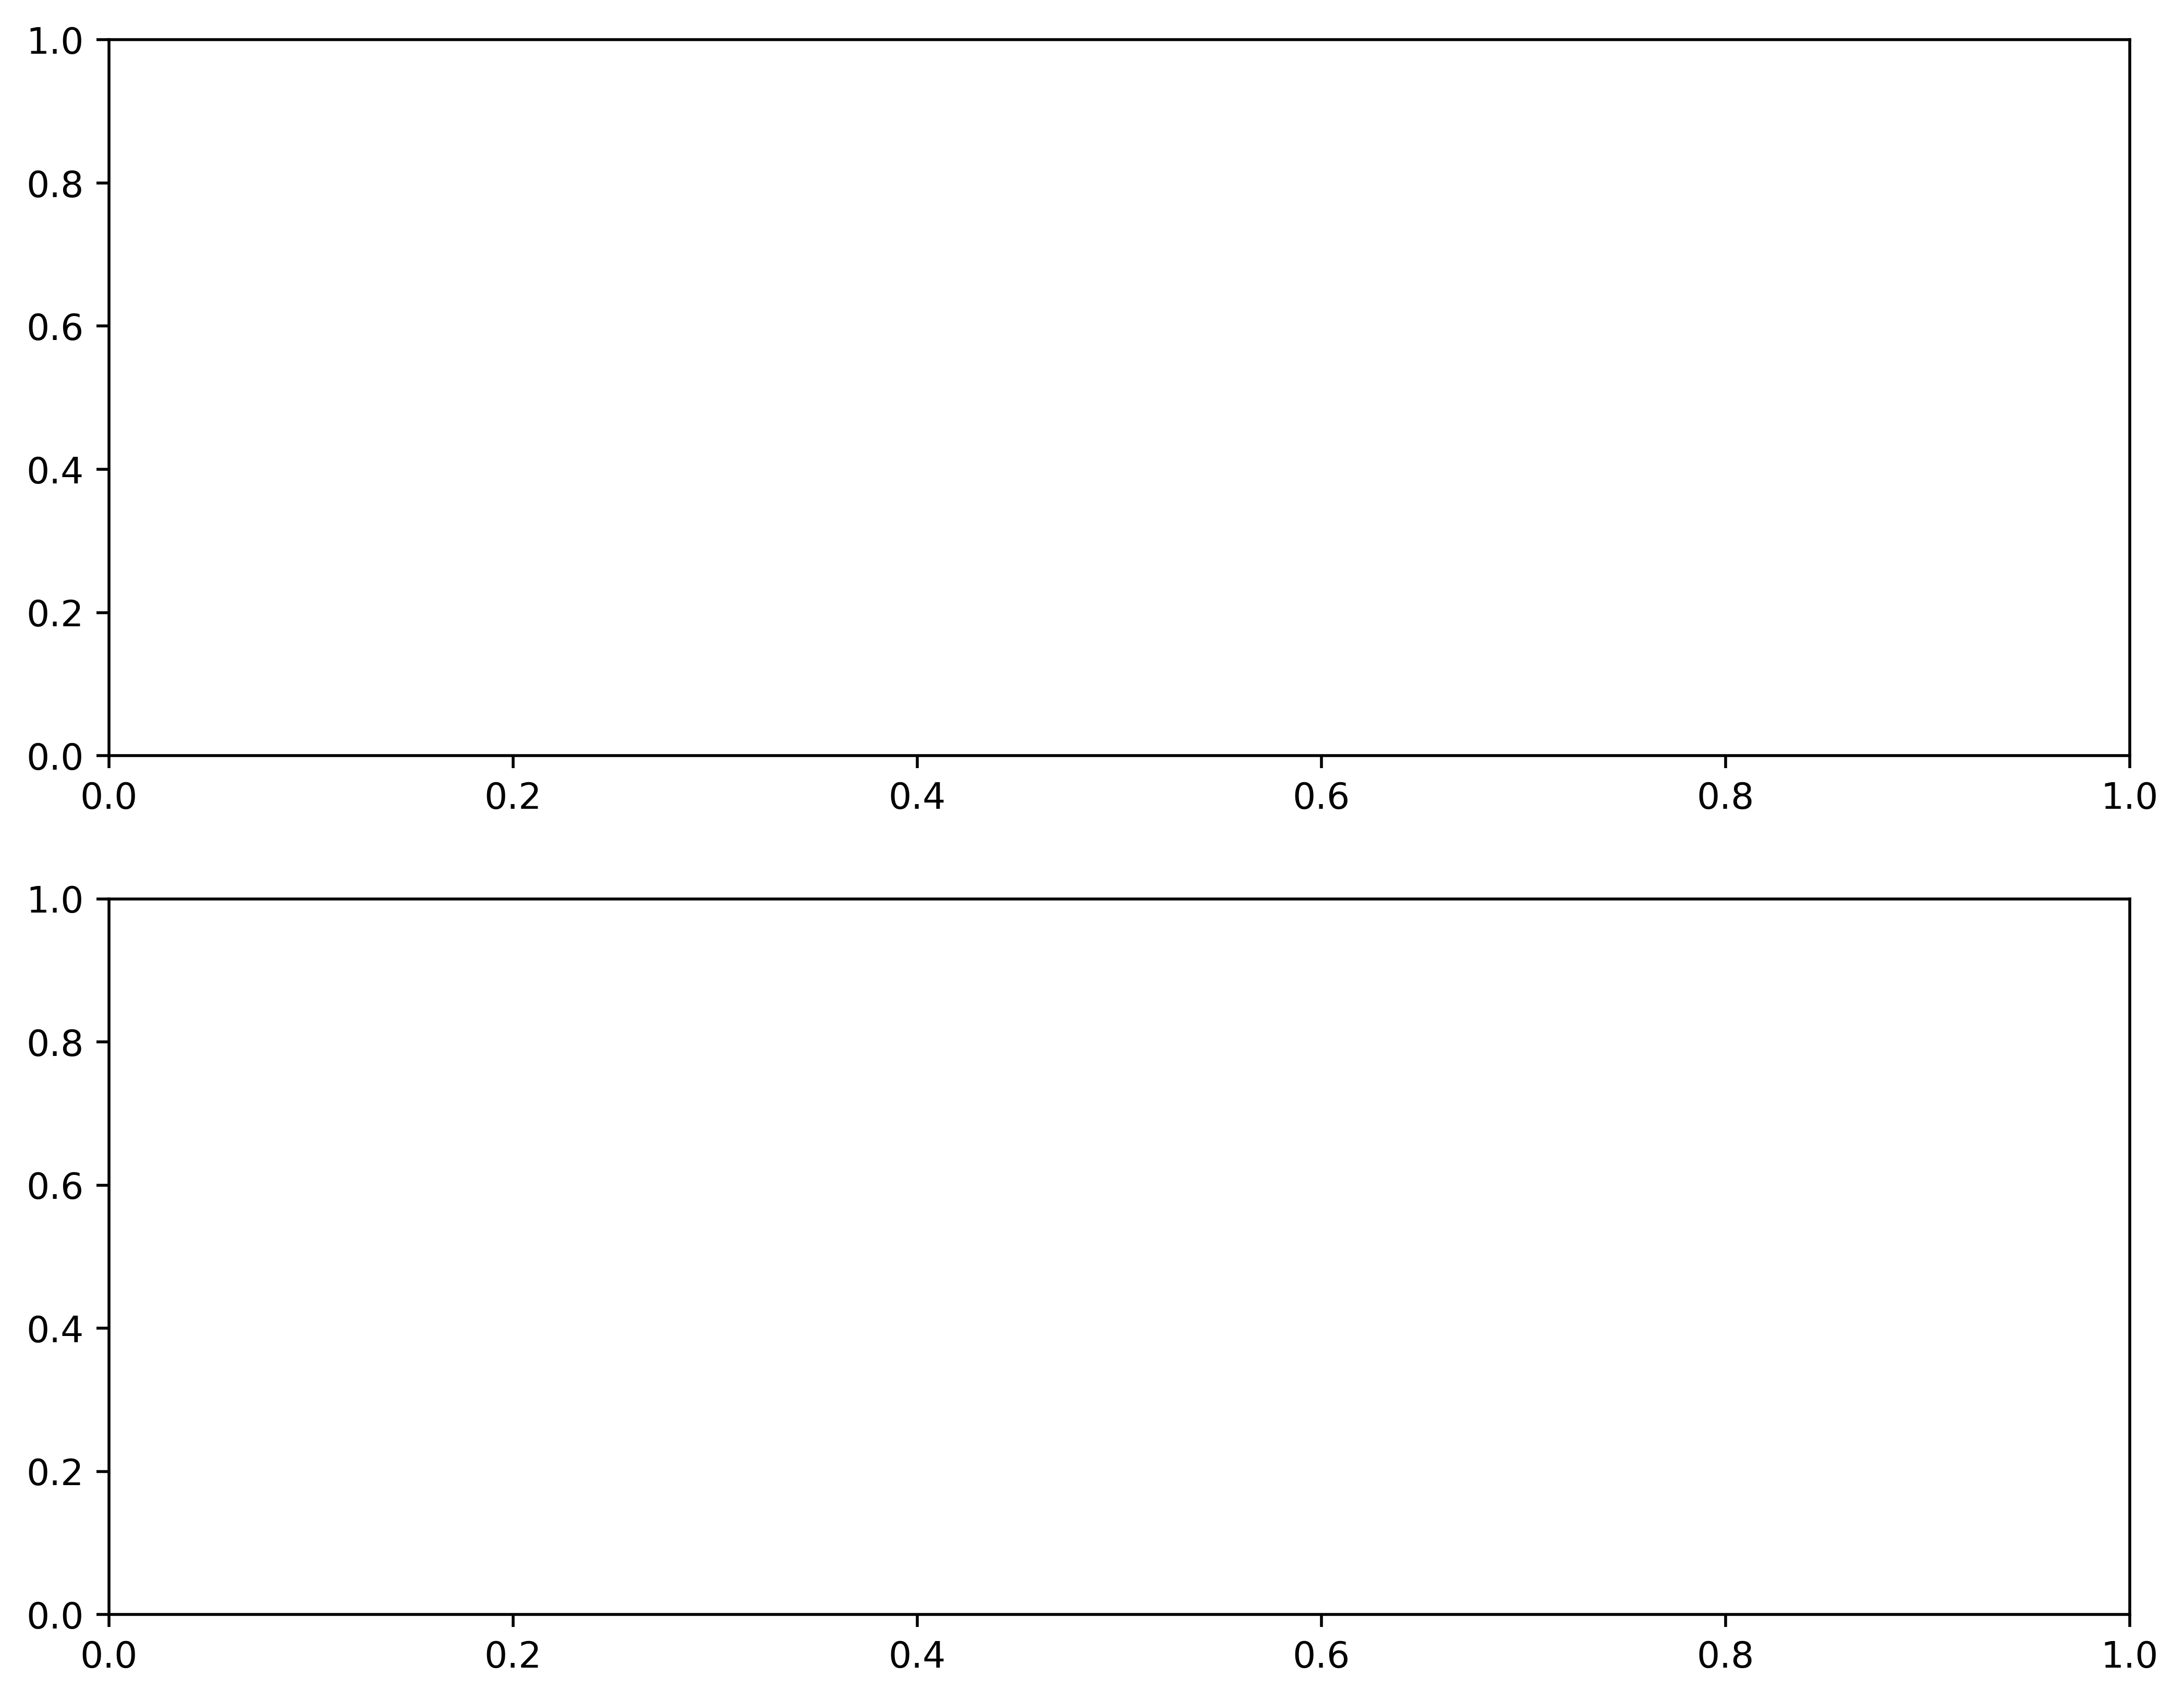

In [45]:
#parameters set here
#################
fPath=r'E:\\CDEX\\ovbb\\calibration\\rootasy\\Spectrum\\calidata\\bin\\'  #file path set here
SaveCsvPath=r'E:\\CDEX\\ovbb\\calibration\\rootasy\\Spectrum\\calidata\\first.csv'  #path to save csv file
ns=1
us=ns*1000
#################
NumOfEvents=10      # number of events

na=1
nb=na+20000
nc=nb+1            #trapezoid shape parameter

MAW=10000          #Moving average window width

Tao=100*us         #time constant  
Ts=1/1.25*ns       #sampling interval
theta=-Ts/Tao
#################

EventInfo=pd.DataFrame(index=np.arange(NumOfEvents),columns=['trapezoid max'])

fig,ax=plt.subplots(2,1,figsize=(10,8),dpi=500)

for i in np.arange(NumOfEvents):
    OrderCode=str(i).zfill(5)
    fName=r'C1J6_No2_remove5Vamps_addC78_100nF_22uF_remove5.4V_withSiPM_DC1Mohm_28.5Vop_'+OrderCode+'.trc'
    ds,dy,d=trc.open(fPath+fName)                        # open file

    Vin=trc.y[0:10000].mean()-trc.y              # mirror the pulse and set ped to zero
    
    diff=10
    ax[0].plot(Vin[62000:63000])
    ax[1].plot(Vin[62000:63000]-Vin[62000-diff:63000-diff])

# #######################block 1 start
#     Vout=TrapShapping(Vin,na,nb,nc,theta)
    
#     Vout[0:nc]=Vout[nc:2*nc].mean()               #eliminate pile-up
    
#     SeriesPulse=pd.Series(Vout.reshape(-1))
    
#     MAPulse=SeriesPulse.rolling(window=MAW).mean() #moving average
    
#     EventInfo['trapezoid max'][i]=MAPulse.max()    #get the max amplitude

# EventInfo.to_csv(path_or_buf=SaveCsvPath)          #save as csv file
# #######################block 1 end